In [1]:
# import environment
from marketsai.mon_policy.env_mon_infin_final import MonPolicy
# import scipy.io as sio
# from scipy.interpolate import RegularGridInterpolator
from scipy.stats import linregress
from marketsai.utils import encode
import matplotlib.pyplot as plt
import pandas as pd
import os
import random


# from sklearn import linear_model
import numpy as np
import seaborn as sn
import math
import csv
import json
from ray.rllib.agents.ppo import PPOTrainer
from ray.tune.registry import register_env
from ray import shutdown, init

""" GLOBAL CONFIGS """
# Script Options
NATIVE = False
TEST = True  # for publication
SAVE_CSV = False  # save learning CSV
PLOT_HIST = True
PLOT_PROGRESS = False  # create plot with progress
SIMUL_EPISODES = 1
ENV_HORIZON = 60
EVAL_RESULTS = True
CHKPT_SELECT_REF = True
RESULTS_REF = np.array([1.3, 0.12, 0.1, 0.0005])
CHKPT_SELECT_MANUAL = False
CHKPT_id = 0
CHKPT_SELECT_MIN = False
CHKPT_SELECT_MAX = False
BETA = 0.95 ** (1 / 12)

# register environment
env_label = "mon_policy"
register_env(env_label, MonPolicy)

# Output Directories

if TEST:
    if NATIVE:
        OUTPUT_PATH_EXPERS = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/ALL/"
        )
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/ALL/"
        )
        OUTPUT_PATH_RESULTS = "~/ray_results/ALL/"
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/ALL/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/ALL/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/ALL/"

else:
    if NATIVE:
        OUTPUT_PATH_EXPERS = "/Users/matiascovarrubias/Dropbox/RL_macro/Experiments/"
        OUTPUT_PATH_FIGURES = (
            "/Users/matiascovarrubias/Dropbox/RL_macro/Documents/Figures/"
        )
        OUTPUT_PATH_RESULTS = "~/ray_results"
    else:
        OUTPUT_PATH_EXPERS = "/scratch/mc5851/Experiments/"
        OUTPUT_PATH_FIGURES = "/scratch/mc5851/Figures/"
        OUTPUT_PATH_RESULTS = "/scratch/mc5851/ray_results/"
# Plot options
sn.color_palette("Set2")
sn.set_style("ticks")  # grid styling, "dark"
# plt.figure(figure=(8, 4))
# choose between "paper", "talk" or "poster"
sn.set_context(
    "paper",
    font_scale=1.4,
)



""" Step 2.0: replicate original environemnt and config """
# environment config
env_config = {
    "horizon": ENV_HORIZON,
    "n_inds": 200,
    "n_firms": 2,
    "eval_mode": False,
    "random_eval": False,
    "analysis_mode": False,
    "noagg": False,
    "regime_change": False,
    "infl_regime": "low",
}

env_config_eval = env_config.copy()
env_config_eval["eval_mode"] = True
env_config_analysis = env_config.copy()
env_config_analysis["analysis_mode"] = True
env_config_deviation = env_config_eval.copy()
env_config_deviation["deviation_mode"] = True
env_config_noagg = env_config_eval.copy()
env_config_noagg["no_agg"] = True
env_config_analysis_noagg = env_config_analysis.copy()
env_config_analysis_noagg["no_agg"] = True

# We instantiate the environment to extract information.
env = MonPolicy(env_config_eval)
config_algo = {
    "gamma": BETA,
    "env": env_label,
    "env_config": env_config_eval,
    "horizon": ENV_HORIZON,
    "explore": False,
    "framework": "torch",
    "multiagent": {
        "policies": {
            "firm_even": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
            "firm_odd": (
                None,
                env.observation_space[0],
                env.action_space[0],
                {},
            ),
        },
        "policy_mapping_fn": (
            lambda agent_id: "firm_even" if agent_id % 2 == 0 else "firm_odd"
        ),
    },
}


/scratch/mc5851/.env/lib/python3.8/site-packages/ray/autoscaler/_private/cli_logger.py:57: FutureWarning: Not all Ray CLI dependencies were found. In Ray 1.4+, the Ray CLI, autoscaler, and dashboard will only be usable via `pip install 'ray[default]'`. Please update your install command.
  warnings.warn(
/scratch/mc5851/.env/lib/python3.8/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


In [2]:

results = {
    "Markups": [],
    "Freq. of Adj.": [],
    "Size of Adj.": [],
    "S.D. of log C": [],
    "Profits": [],
}

results_raw=[]

for i in range(34):

    if i<2:
        TRIAL_PATH_1 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_5edcc_0000{i}_{i}_2021-11-16_10-53-41/"
    elif i<10:
        TRIAL_PATH_1 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_5edcc_0000{i}_{i}_2021-11-16_10-53-42/"
    else:
        TRIAL_PATH_1 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_5edcc_000{i}_{i}_2021-11-16_10-53-42/"

    if i<8:
        TRIAL_PATH_2 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_bd5e6_0000{i}_{i}_2021-11-16_10-49-10/"
    elif i<10:
        TRIAL_PATH_2 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_bd5e6_0000{i}_{i}_2021-11-16_10-49-11/"
    else:
        TRIAL_PATH_2 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_bd5e6_000{i}_{i}_2021-11-16_10-49-11/"

    if i<5:
        TRIAL_PATH_3 = f"/scratch/mc5851/ray_results/server_mon_infin_2_exp_0_Nov15_PPO_run/PPO_mon_infin_2_27571_0000{i}_{i}_2021-11-16_10-52-08/"
    elif i<10:
        TRIAL_PATH_3 = f"/scratch/mc5851/ray_results/server_mon_infin_2_exp_0_Nov15_PPO_run/PPO_mon_infin_2_27571_0000{i}_{i}_2021-11-16_10-52-09/"
    else:
        TRIAL_PATH_3 = f"/scratch/mc5851/ray_results/server_mon_infin_2_exp_0_Nov15_PPO_run/PPO_mon_infin_2_27571_000{i}_{i}_2021-11-16_10-52-09/"

    elem=0
    for line in open(TRIAL_PATH_1+'result.json', 'r'):
            
        elem += 1
        if elem==5000:
            results_raw.append(json.loads(line))
            results["Markups"].append(results_raw[-1]["evaluation"]['custom_metrics']['mean_markup_ij_mean'])
            results["Freq. of Adj."].append(results_raw[-1]["evaluation"]['custom_metrics']['freq_p_adj_mean'])
            results["Size of Adj."].append(results_raw[-1]["evaluation"]['custom_metrics']['size_adj_mean'])
            results["S.D. of log C"].append(results_raw[-1]["evaluation"]['custom_metrics']['std_log_c_mean'])
            results["Profits"].append(results_raw[-1]["evaluation"]['custom_metrics']['profits_mean'])
    elem=0
    for line in open(TRIAL_PATH_2+'result.json', 'r'):
        elem += 1
        if elem==5000:
            results_raw.append(json.loads(line))
            results["Markups"].append(results_raw[-1]["evaluation"]['custom_metrics']['mean_markup_ij_mean'])
            results["Freq. of Adj."].append(results_raw[-1]["evaluation"]['custom_metrics']['freq_p_adj_mean'])
            results["Size of Adj."].append(results_raw[-1]["evaluation"]['custom_metrics']['size_adj_mean'])
            results["S.D. of log C"].append(results_raw[-1]["evaluation"]['custom_metrics']['std_log_c_mean'])
            results["Profits"].append(results_raw[-1]["evaluation"]['custom_metrics']['profits_mean'])
    elem=0
    for line in open(TRIAL_PATH_3+'result.json', 'r'):
        elem += 1
        if elem==5000:
            results_raw.append(json.loads(line))
            results["Markups"].append(results_raw[-1]["evaluation"]['custom_metrics']['mean_markup_ij_mean'])
            results["Freq. of Adj."].append(results_raw[-1]["evaluation"]['custom_metrics']['freq_p_adj_mean'])
            results["Size of Adj."].append(results_raw[-1]["evaluation"]['custom_metrics']['size_adj_mean'])
            results["S.D. of log C"].append(results_raw[-1]["evaluation"]['custom_metrics']['std_log_c_mean'])
            results["Profits"].append(results_raw[-1]["evaluation"]['custom_metrics']['profits_mean'])

#
results_stats = {
    "Mean Markups": np.mean(results["Markups"]),
    "S.D. Markups": np.std(results["Markups"]),
    "Mean Freq. of Adj.": np.mean(results["Freq. of Adj."]),
    "S.D. Freq. of Adj.": np.std(results["Freq. of Adj."]),
    "Mean Size of Adj.": np.mean(results["Size of Adj."]),
    "S.D. Size of Adj.": np.std(results["Size of Adj."]),
    "Mean S.D. of log C": np.mean(results["S.D. of log C"]),
    "S.D. S.D. of log C": np.std(results["S.D. of log C"]),
    "Mean Profits": np.mean(results["Profits"]),
    "S.D. Profits": np.std(results["Profits"]),
}

print(results_stats)


{'Mean Markups': 1.3876070104183327, 'S.D. Markups': 0.06237117731353384, 'Mean Freq. of Adj.': 0.07318081994206309, 'S.D. Freq. of Adj.': 0.037732379797890854, 'Mean Size of Adj.': 0.15530311689543436, 'S.D. Size of Adj.': 0.05690229110809665, 'Mean S.D. of log C': 0.05146782810274029, 'S.D. S.D. of log C': 0.00959673853922768, 'Mean Profits': 0.10843193237982582, 'S.D. Profits': 0.014264971244960371}


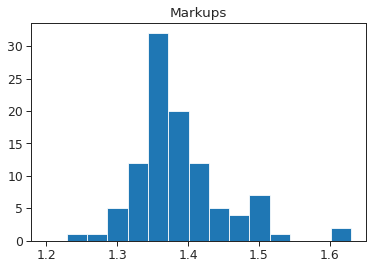

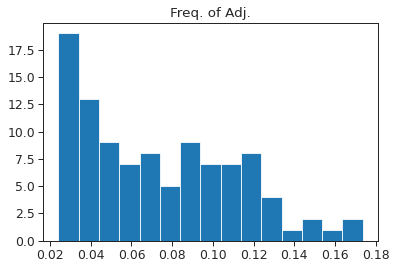

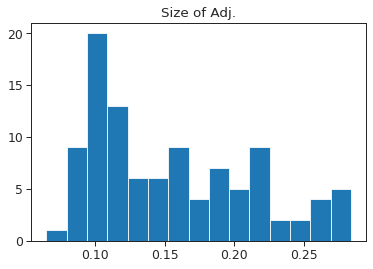

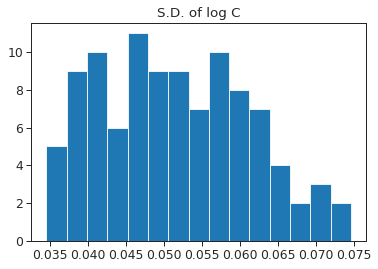

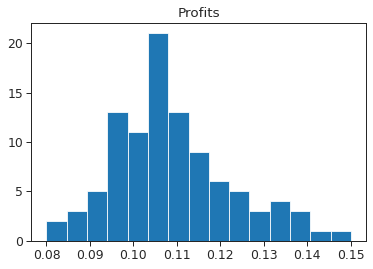

[[ 1.          0.16728374 -0.20965978  0.26385435]
 [ 0.16728374  1.         -0.89613832 -0.69013645]
 [-0.20965978 -0.89613832  1.          0.65979336]
 [ 0.26385435 -0.69013645  0.65979336  1.        ]]


In [5]:
""" Analysis of Results """

#Plot histograms
#results["Markups"] =[i if i>1.3 else 1.38 for i in results["Markups"]]
for i, x in results.items():
    if i=="Markups":
         plt.hist(x, bins=15, range=(1.2,1.63))
    elif i=="Profits":
            plt.hist(x, bins=15, range=(0.08,0.15))
    else:
        plt.hist(x, bins=15)
    plt.title(i)
    plt.savefig(
        OUTPUT_PATH_FIGURES + "hist_" + f"{i}" + "_" + "infin_Nov15" + ".png"
    )
    plt.show()
    plt.close()

print(np.corrcoef([results["Markups"],results["Freq. of Adj."],results["Size of Adj."],results["S.D. of log C"]]))

In [4]:
CHKPT_SELECT_REF = True
RESULTS_REF = np.array([1.5, 0.08, 0.15, 0.06])
CHKPT_SELECT_MANUAL = False
CHKPT_id = 0
CHKPT_SELECT_MIN = False
CHKPT_SELECT_MAX = False


""" Select checkpoint for analysis """
checkpoints = []

NUM_TRIALS = len(results["Markups"])

for i in range(34):

    if i<2:
        TRIAL_PATH_1 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_5edcc_0000{i}_{i}_2021-11-16_10-53-41/"
    elif i<10:
        TRIAL_PATH_1 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_5edcc_0000{i}_{i}_2021-11-16_10-53-42/"
    else:
        TRIAL_PATH_1 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_5edcc_000{i}_{i}_2021-11-16_10-53-42/"

    if i<8:
        TRIAL_PATH_2 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_bd5e6_0000{i}_{i}_2021-11-16_10-49-10/"
    elif i<10:
        TRIAL_PATH_2 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_bd5e6_0000{i}_{i}_2021-11-16_10-49-11/"
    else:
        TRIAL_PATH_2 = f"/scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_bd5e6_000{i}_{i}_2021-11-16_10-49-11/"

    if i<5:
        TRIAL_PATH_3 = f"/scratch/mc5851/ray_results/server_mon_infin_2_exp_0_Nov15_PPO_run/PPO_mon_infin_2_27571_0000{i}_{i}_2021-11-16_10-52-08/"
    elif i<10:
        TRIAL_PATH_3 = f"/scratch/mc5851/ray_results/server_mon_infin_2_exp_0_Nov15_PPO_run/PPO_mon_infin_2_27571_0000{i}_{i}_2021-11-16_10-52-09/"
    else:
        TRIAL_PATH_3 = f"/scratch/mc5851/ray_results/server_mon_infin_2_exp_0_Nov15_PPO_run/PPO_mon_infin_2_27571_000{i}_{i}_2021-11-16_10-52-09/"
    
    checkpoints.append(TRIAL_PATH_1 + "checkpoint_005000/checkpoint-5000")
    checkpoints.append(TRIAL_PATH_2 + "checkpoint_005000/checkpoint-5000")
    checkpoints.append(TRIAL_PATH_3 + "checkpoint_005000/checkpoint-5000")

results_list = [
    [
        results["Markups"][i],
        results["Freq. of Adj."][i],
        results["Size of Adj."][i],
        results["S.D. of log C"][i],
    ]
    for i in range(NUM_TRIALS)
]

if CHKPT_SELECT_REF:

    distance_agg = np.array(
        [
            (
                (results["Markups"][i] - RESULTS_REF[0])
                / results_stats["S.D. Markups"]
            )
            ** 2
            + (
                (results["Freq. of Adj."][i] - RESULTS_REF[1])
                / results_stats["S.D. Freq. of Adj."]
            )
            ** 2
            + (
                (results["Size of Adj."][i] - RESULTS_REF[2])
                / results_stats["S.D. Size of Adj."]
            )
            ** 2
            + (
                (results["S.D. of log C"][i] - RESULTS_REF[3])
                / results_stats["S.D. S.D. of log C"]
            )
            ** 2
            for i in range(NUM_TRIALS)
        ]
    )

    selected_id = distance_agg.argmin()

if CHKPT_SELECT_MIN:
    selected_id = results["Markups"].argmin()

if CHKPT_SELECT_MAX:
    selected_id = results["Markups"].argmax()

if CHKPT_SELECT_MANUAL:
    selected_id = CHKPT_id

print("Selected chekpoint;", results_list[selected_id])
INPUT_PATH_CHECKPOINT = checkpoints[selected_id]

#print("results_stats:", results_stats)
#print("results_list:", results_list)

Selected chekpoint; [1.475637915381656, 0.06646593040216713, 0.1387195356768435, 0.05587176316842962]


2021-11-27 18:41:44,872	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-11-27 18:41:49,363	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-11-27 18:41:49,429	INFO trainable.py:377 -- Restored on 10.32.34.120 from checkpoint: /scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_5edcc_00006_6_2021-11-16_10-53-42/checkpoint_005000/checkpoint-5000
2021-11-27 18:41:49,430	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 5000, '_timesteps_total': None, '_time_total': 19435.192585468292, '_episodes_total': 5000}


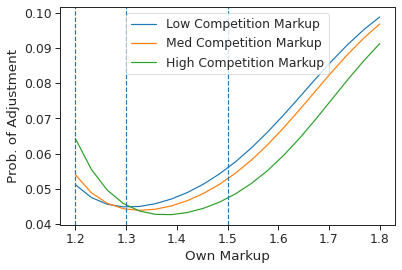

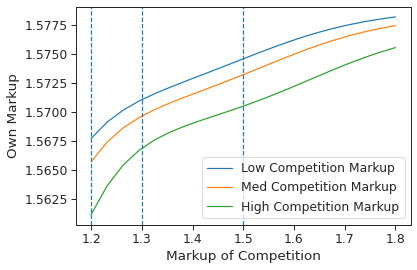

Slope of own react, low [0.09282078132742931, 0.016613207757472995]
Slope of own react, med [0.08567687088534948, 0.018106982466720413]
Slope of own react, high [0.0613347398383277, 0.020381536512147823]


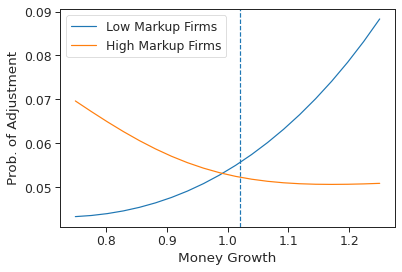

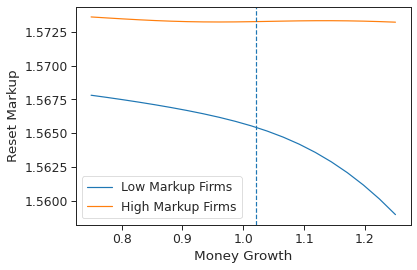

Slope to mon, low [0.08778111764362878, 0.08778111764362878]
Slope to mon, high [-0.03601490855216979, -0.0004102442945752824]


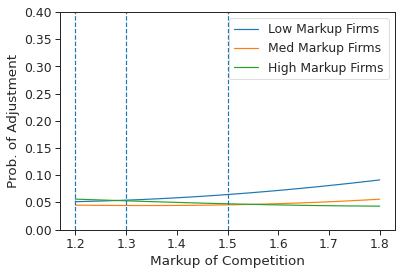

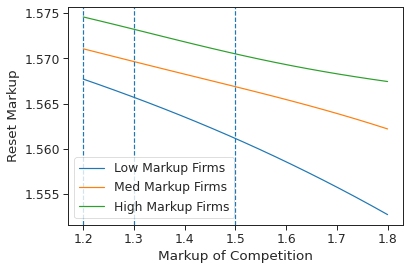

Slope of react, low [0.06700175645805544, -0.024926601598660163]
Slope of react, med [0.01751208447274708, -0.014528974181129821]
Slope of react, high [-0.022147146009263544, -0.012167490486587799]


In [7]:


shutdown()
init(
    num_cpus = 48,
    log_to_driver=False,
)

# register environment
env_label = "mon_policy"
register_env(env_label, MonPolicy)
config_algo["explore"] = False
trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)
exp_names = ["Nov15infin"]
OBS_IDSHOCK = False
""" Policy function with respect to own markup"""

markup = [1.2 + (i / 19)*(0.6) for i in range(20)]
if not OBS_IDSHOCK:
    obs_reaction_lowmu = [
        np.array(
            [markup[i], 1.2] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_medmu = [
        np.array(
            [markup[i], 1.3] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_highmu = [
        np.array(
            [markup[i], 1.5] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
else:
    obs_reaction_lowmu = [
        np.array(
            [markup[i], 1.2, 1, 1] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_medmu = [
        np.array(
            [markup[i], 1.3, 1, 1] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_highmu = [
        np.array(
            [markup[i], 1.5, 1, 1] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]

actions_reaction_lowmu = [
    trained_trainer.compute_action(obs_reaction_lowmu[i], policy_id="firm_even")
    for i in range(20)
]
actions_reaction_medmu = [
    trained_trainer.compute_action(obs_reaction_medmu[i], policy_id="firm_even")
    for i in range(20)
]
actions_reaction_highmu = [
    trained_trainer.compute_action(obs_reaction_highmu[i], policy_id="firm_even")
    for i in range(20)
]
move_prob_lowmu = [(actions_reaction_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [1 + (actions_reaction_lowmu[i][1] + 1) / 2 for i in range(20)]
move_prob_medmu = [(actions_reaction_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [1 + (actions_reaction_medmu[i][1] + 1) / 2 for i in range(20)]
move_prob_highmu = [(actions_reaction_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [1 + (actions_reaction_highmu[i][1] + 1) / 2 for i in range(20)]

x = markup
plt.plot(x, move_prob_lowmu)
plt.plot(x, move_prob_medmu)
plt.plot(x, move_prob_highmu)
plt.axvline(x=1.2, linestyle='--')
plt.axvline(x=1.3, linestyle='--')
plt.axvline(x=1.5, linestyle='--')
plt.legend(
    ["Low Competition Markup", "Med Competition Markup", "High Competition Markup"]
)
plt.xlabel("Own Markup")
plt.ylabel("Prob. of Adjustment")
# plt.title("Probability of Adjustment")
# plt.title("MIN")

plt.savefig(OUTPUT_PATH_FIGURES + "polown_prob_" + "_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu)
plt.plot(x, reset_medmu)
plt.plot(x, reset_highmu)
plt.axvline(x=1.2, linestyle='--')
plt.axvline(x=1.3, linestyle='--')
plt.axvline(x=1.5, linestyle='--')
plt.legend(
    ["Low Competition Markup", "Med Competition Markup", "High Competition Markup"]
)
plt.xlabel("Markup of Competition")
plt.ylabel("Own Markup")
# plt.title("Reset Markup")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polown_reset_" + "_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

reg_react_prob_low = linregress(markup, move_prob_lowmu)
reg_react_prob_med = linregress(markup, move_prob_medmu)
reg_react_prob_high = linregress(markup, move_prob_highmu)
reg_react_reset_low = linregress(markup, reset_lowmu)
reg_react_reset_med = linregress(markup, reset_medmu)
reg_react_reset_high = linregress(markup, reset_highmu)
slope_react_prob_low = reg_react_prob_low[0]
slope_react_prob_med = reg_react_prob_med[0]
slope_react_prob_high = reg_react_prob_high[0]
slope_react_reset_low = reg_react_reset_low[0]
slope_react_reset_med = reg_react_reset_med[0]
slope_react_reset_high = reg_react_reset_high[0]

print("Slope of own react, low", [slope_react_prob_low, slope_react_reset_low])
print("Slope of own react, med", [slope_react_prob_med, slope_react_reset_med])
print("Slope of own react, high", [slope_react_prob_high, slope_react_reset_high])

""" Policy Function with respect to monetary policy. """

mon_policy = [0.75       
    + (i / 19) * 0.5
    for i in range(20)
]
# print(mon_policy)
if not OBS_IDSHOCK:
    obs_monpol_lowmu = [
        np.array([1.2, 1.3] + [1.3185, mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
    obs_monpol_medmu = [
        np.array([1.3, 1.3] + [1.3185, mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
    obs_monpol_highmu = [
        np.array([1.5, 1.3] + [1.3185, mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
else:
    obs_monpol_lowmu = [
        np.array([1.2, 1.3, 1, 1] + [1.3185, mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
    obs_monpol_medmu = [
        np.array([1.3, 1.3, 1, 1] + [1.3185, mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]
    obs_monpol_highmu = [
        np.array([1.5, 1.3, 1, 1] + [1.3185, mon_policy[i]], dtype=np.float32)
        for i in range(20)
    ]

actions_monpol_lowmu = [
    trained_trainer.compute_action(obs_monpol_lowmu[i], policy_id="firm_even")
    for i in range(20)
]
actions_monpol_medmu = [
    trained_trainer.compute_action(obs_monpol_medmu[i], policy_id="firm_even")
    for i in range(20)
]
actions_monpol_highmu = [
    trained_trainer.compute_action(obs_monpol_highmu[i], policy_id="firm_even")
    for i in range(20)
]
move_prob_lowmu = [(actions_monpol_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [1 + (actions_monpol_lowmu[i][1] + 1) / 2 for i in range(20)]
move_prob_medmu = [(actions_monpol_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [1 + (actions_monpol_medmu[i][1] + 1) / 2 for i in range(20)]
move_prob_highmu = [(actions_monpol_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [1 + (actions_monpol_highmu[i][1] + 1) / 2 for i in range(20)]
# print(actions_monpol_lowmu, "\n",
#     actions_monpol_highmu)
x = mon_policy
plt.plot(x, move_prob_lowmu)
# plt.plot(x,move_prob_medmu)
plt.plot(x, move_prob_highmu)
plt.axvline(x=1.0212, linestyle='--')
plt.legend(["Low Markup Firms", "High Markup Firms"])
plt.xlabel("Money Growth")
plt.ylabel("Prob. of Adjustment")
# plt.title("Effect of money growth on Prob. of Adj.")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polmon_prob_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu)
# plt.plot(x,reset_medmu)
plt.plot(x, reset_highmu)
plt.axvline(x=1.0212, linestyle='--')
plt.legend(["Low Markup Firms", "High Markup Firms"])
plt.xlabel("Money Growth")
plt.ylabel("Reset Markup")

# plt.title("Effec of money growth on Size of Adj.")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polmon_reset_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

reg_mon_prob_low = linregress(mon_policy, move_prob_lowmu)
slope_mon_prob_low = reg_mon_prob_low[0]
reg_mon_prob_high = linregress(mon_policy, move_prob_highmu)
slope_mon_prob_high = reg_mon_prob_high[0]

reg_mon_reset_low = linregress(mon_policy, reset_lowmu)
slope_mon_reset_low = reg_mon_prob_low[0]
reg_mon_reset_high = linregress(mon_policy, reset_highmu)
slope_mon_reset_high = reg_mon_reset_high[0]

print("Slope to mon, low", [slope_mon_prob_low, slope_mon_reset_low])
print("Slope to mon, high", [slope_mon_prob_high, slope_mon_reset_high])

""" Reaction Function to comepition markup with constant z """

markup = [1.2 + (i / 19)*0.6 for i in range(20)]
if not OBS_IDSHOCK:
    obs_reaction_lowmu = [
        np.array(
            [1.2, markup[i]] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_medmu = [
        np.array(
            [1.3, markup[i]] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_highmu = [
        np.array(
            [1.5, markup[i]] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
else:
    obs_reaction_lowmu = [
        np.array(
            [1.2, markup[i], 1, 1] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_medmu = [
        np.array(
            [1.3, markup[i], 1, 1] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]
    obs_reaction_highmu = [
        np.array(
            [1.5, markup[i], 1, 1] + [1.3185, math.e ** env.params["log_g_bar"]],
            dtype=np.float32,
        )
        for i in range(20)
    ]

actions_reaction_lowmu = [
    trained_trainer.compute_action(obs_reaction_lowmu[i], policy_id="firm_even")
    for i in range(20)
]
actions_reaction_medmu = [
    trained_trainer.compute_action(obs_reaction_medmu[i], policy_id="firm_even")
    for i in range(20)
]
actions_reaction_highmu = [
    trained_trainer.compute_action(obs_reaction_highmu[i], policy_id="firm_even")
    for i in range(20)
]
move_prob_lowmu = [(actions_reaction_lowmu[i][0] + 1) / 2 for i in range(20)]
reset_lowmu = [1 + (actions_reaction_lowmu[i][1] + 1) / 2 for i in range(20)]
move_prob_medmu = [(actions_reaction_medmu[i][0] + 1) / 2 for i in range(20)]
reset_medmu = [1 + (actions_reaction_medmu[i][1] + 1) / 2 for i in range(20)]
move_prob_highmu = [(actions_reaction_highmu[i][0] + 1) / 2 for i in range(20)]
reset_highmu = [1 + (actions_reaction_highmu[i][1] + 1) / 2 for i in range(20)]

x = markup
plt.plot(x, move_prob_lowmu)
plt.plot(x, move_prob_medmu)
plt.plot(x, move_prob_highmu)
plt.axvline(x=1.2, linestyle='--')
plt.axvline(x=1.3, linestyle='--')
plt.axvline(x=1.5, linestyle='--')
plt.ylim([0, 0.4])
plt.legend(["Low Markup Firms", "Med Markup Firms", "High Markup Firms"])
plt.xlabel("Markup of Competition")
plt.ylabel("Prob. of Adjustment")
# plt.title("Reaction Function - Probability of Adjustment")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polreact_prob_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

plt.plot(x, reset_lowmu)
plt.plot(x, reset_medmu)
plt.plot(x, reset_highmu)
plt.axvline(x=1.2, linestyle='--')
plt.axvline(x=1.3, linestyle='--')
plt.axvline(x=1.5, linestyle='--')
plt.legend(["Low Markup Firms", "Med Markup Firms", "High Markup Firms"])
plt.xlabel("Markup of Competition")
plt.ylabel("Reset Markup")
# plt.title("Reaction Function - Reset Markup")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "polreact_reset_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

reg_react_prob_low = linregress(markup, move_prob_lowmu)
reg_react_prob_med = linregress(markup, move_prob_medmu)
reg_react_prob_high = linregress(markup, move_prob_highmu)
reg_react_reset_low = linregress(markup, reset_lowmu)
reg_react_reset_med = linregress(markup, reset_medmu)
reg_react_reset_high = linregress(markup, reset_highmu)
slope_react_prob_low = reg_react_prob_low[0]
slope_react_prob_med = reg_react_prob_med[0]
slope_react_prob_high = reg_react_prob_high[0]
slope_react_reset_low = reg_react_reset_low[0]
slope_react_reset_med = reg_react_reset_med[0]
slope_react_reset_high = reg_react_reset_high[0]

print("Slope of react, low", [slope_react_prob_low, slope_react_reset_low])
print("Slope of react, med", [slope_react_prob_med, slope_react_reset_med])
print("Slope of react, high", [slope_react_prob_high, slope_react_reset_high])



2021-11-27 17:27:47,352	INFO services.py:1272 -- View the Ray dashboard at http://127.0.0.1:8265
2021-11-27 17:27:51,949	WARNING util.py:53 -- Install gputil for GPU system monitoring.
2021-11-27 17:27:51,968	INFO trainable.py:377 -- Restored on 10.32.34.120 from checkpoint: /scratch/mc5851/ray_results/server_mon_infin_1_exp_0_Nov15_PPO_run/PPO_mon_infin_1_5edcc_00006_6_2021-11-16_10-53-42/checkpoint_005000/checkpoint-5000
2021-11-27 17:27:51,969	INFO trainable.py:385 -- Current state after restoring: {'_iteration': 5000, '_timesteps_total': None, '_time_total': 19435.192585468292, '_episodes_total': 5000}


0
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
900
950
1000
1050
1100
1150
1200
1250
1300
1350
1400
1450
1500
1550
1600
1650
1700
1750
1800
1850
1900
1950
2000
2050
2100
2150
2200
2250
2300
2350
2400
2450
2500
2550
2600
2650
2700
2750
2800
2850
2900
2950
3000
3050
3100
3150
3200
3250
3300
3350
3400
3450
3500
3550
3600
3650
3700
3750
3800
3850
3900
3950
4000
4050
4100
4150
4200
4250
4300
4350
4400
4450
4500
4550
4600
4650
4700
4750
4800
4850
4900
4950
corr betweeen cons: [[1.         0.08102218]
 [0.08102218 1.        ]]
corr betweeen z: [[1. 1.]
 [1. 1.]]
cum_IRs_freqlow: -0.9636800609348493 
 cum_IRs_freqhigh: 0.5751425542271633 
 cum_IRs_sizelow: -2.8453449688940653 
 cum_IRs_sizehigh: 2.0306014019753125 

Simul_results_dict: {'Mean Profits': [0.13021691644150077], 'S.D. Profits': [0.024246615917548148], 'Max Profits': [0.1962573550220749], 'Min Profits': [0.006184358433525493], 'Mean Markups': [1.4712750423979892], 'S.D. Markups': [0.08299818332289106], 'Max Ma

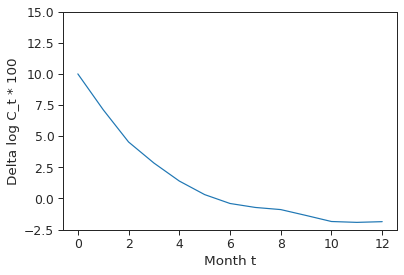

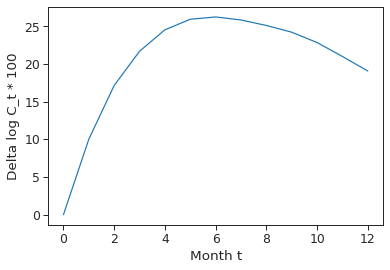

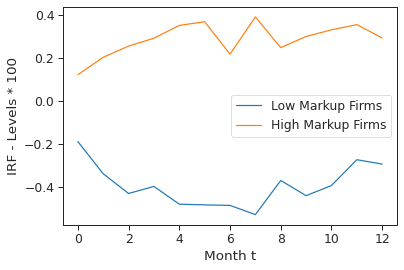

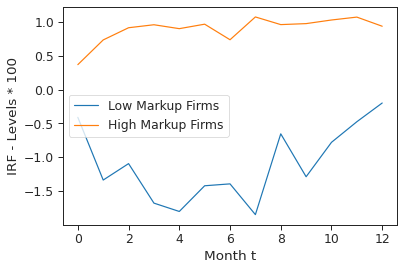

In [6]:
""" SIMULATE EPSIODES AND CALCULATE REGRESSIONS"""

shutdown()
init(
    num_cpus=12,
    log_to_driver=False,
)
# register environment
env_label = "mon_policy_finite"
register_env(env_label, MonPolicy)
# We instantiate the environment to extract information.
""" CHANGE HERE """
ENV_HORIZON = 5000
env_config_eval["horizon"] = 5000
env_config_simul = env_config_eval.copy()
env_config_simul["random_eval"] = False
#env_config_simul["n_inds"]=5000
env_config_simul["horizon"] = SIMUL_EPISODES*ENV_HORIZON
env_config_noagg = env_config_simul.copy()
env_config_noagg["no_agg"] = True
env = MonPolicy(env_config_simul)
env_noagg = MonPolicy(env_config_noagg)

""" Restore trainer """

# restore the trainer

trained_trainer = PPOTrainer(env=env_label, config=config_algo)
trained_trainer.restore(INPUT_PATH_CHECKPOINT)

""" Simulate an episode (SIMUL_PERIODS timesteps) """
profits_list = []
mu_ij_list = []
mu_list = []
freq_p_adj_list = []
size_adj_list = []
freq_adj_lowmu_list = []
freq_adj_highmu_list = []
size_adj_list = []
size_adj_lowmu_list = []
size_adj_highmu_list = []
z_list = []
log_c_list = []
epsilon_g_list = []

profits_list_noagg = []
mu_ij_list_noagg = []
mu_list_noagg = []
freq_p_adj_list_noagg = []
freq_adj_lowmu_list_noagg = []
freq_adj_highmu_list_noagg = []
size_adj_list_noagg = []
size_adj_lowmu_list_noagg = []
size_adj_highmu_list_noagg = []
z_list_noagg = []
log_c_list_noagg = []

log_c_filt_list = []
freq_adj_lowmu_filt_list = []
freq_adj_highmu_filt_list = []
size_adj_lowmu_filt_list = []
size_adj_highmu_filt_list = []

# loop with agg
seed = random.randrange(100000)
env.seed_eval = seed
env_noagg.seed_eval = seed
obs = env.reset()
obs_noagg = env_noagg.reset()
for t in range(SIMUL_EPISODES * ENV_HORIZON):
    if t % 50 == 0:
        print(t)
    # if t % env.horizon == 0:
    #     seed = random.randrange(100000)
    #     env.seed_eval = seed
    #     env_noagg.seed_eval = seed
    #     print("time:", t)
    #     obs = env.reset()
    #     obs_noagg = env_noagg.reset()
    action = {
        i: trained_trainer.compute_action(obs[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs[i], policy_id="firm_odd")
        for i in range(env.n_agents)
    }
    action_noagg = {
        i: trained_trainer.compute_action(obs_noagg[i], policy_id="firm_even")
        if i % 2 == 0
        else trained_trainer.compute_action(obs_noagg[i], policy_id="firm_odd")
        for i in range(env.n_agents)
    }

    obs, rew, done, info = env.step(action)
    obs_noagg, rew_noagg, done_noagg, info_noagg = env_noagg.step(action_noagg)

    profits_list.append(info[0]["mean_profits"])
    mu_ij_list.append(info[0]["mean_mu_ij"])
    mu_list.append(info[0]["mu"])
    freq_p_adj_list.append(info[0]["move_freq"])
    freq_adj_lowmu_list.append(info[0]["move_freq_lowmu"])
    freq_adj_highmu_list.append(info[0]["move_freq_highmu"])
    size_adj_list.append(info[0]["mean_p_change"])
    size_adj_lowmu_list.append(info[0]["size_adj_lowmu"])
    size_adj_highmu_list.append(info[0]["size_adj_highmu"])
    log_c_list.append(info[0]["log_c"])
    epsilon_g_list.append(env.epsilon_g)
    z_list.append(env.epsilon_z[0])
    profits_list_noagg.append(info_noagg[0]["mean_profits"])
    mu_ij_list_noagg.append(info_noagg[0]["mean_mu_ij"])
    mu_list_noagg.append(info_noagg[0]["mu"])
    freq_p_adj_list_noagg.append(info_noagg[0]["move_freq"])
    freq_adj_lowmu_list_noagg.append(info_noagg[0]["move_freq_lowmu"])
    freq_adj_highmu_list_noagg.append(info_noagg[0]["move_freq_highmu"])
    size_adj_list_noagg.append(info_noagg[0]["mean_p_change"])
    size_adj_lowmu_list_noagg.append(info_noagg[0]["size_adj_lowmu"])
    size_adj_highmu_list_noagg.append(info_noagg[0]["size_adj_highmu"])
    log_c_list_noagg.append(info_noagg[0]["log_c"])
    log_c_filt_list.append(log_c_list[-1] - log_c_list_noagg[-1])
    freq_adj_lowmu_filt_list.append(
        freq_adj_lowmu_list[-1] - freq_adj_lowmu_list_noagg[-1]
    )
    freq_adj_highmu_filt_list.append(
        freq_adj_highmu_list[-1] - freq_adj_highmu_list_noagg[-1]
    )
    size_adj_lowmu_filt_list.append(
        size_adj_lowmu_list[-1] - size_adj_lowmu_list_noagg[-1]
    )
    size_adj_highmu_filt_list.append(
        size_adj_highmu_list[-1] - size_adj_highmu_list_noagg[-1]
    )
    z_list_noagg.append(env_noagg.epsilon_z[0])

""" PLOT IRS and PROCESS RESULTS"""

simul_results_dict = {
    "Mean Profits": [],
    "S.D. Profits": [],
    "Max Profits": [],
    "Min Profits": [],
    "Mean Markups": [],
    "S.D. Markups": [],
    "Max Markups": [],
    "Min Markups": [],
    "Mean Freq. of Adj.": [],
    "S.D. Freq. of Adj.": [],
    "Max Freq. of Adj.": [],
    "Min Freq. of Adj.": [],
    "Mean Size of Adj.": [],
    "S.D. Size of Adj.": [],
    "Max Size of Adj.": [],
    "Min Size of Adj.": [],
    "Mean Agg. Markup": [],
    "S.D. log C": [],
    "IRs": [],
    "cum_IRs": [],
}
# epsilon_g_pereps = [
#     epsilon_g_list[i * ENV_HORIZON : i * ENV_HORIZON + ENV_HORIZON]
#     for i in range(SIMUL_EPISODES)
# ]
# log_c_filt_pereps = [
#     log_c_filt_list[i * ENV_HORIZON : i * ENV_HORIZON + ENV_HORIZON]
#     for i in range(SIMUL_EPISODES)
# ]
# freq_adj_lowmu_pereps = [
#     freq_adj_lowmu_filt_list[i * ENV_HORIZON : i * ENV_HORIZON + ENV_HORIZON]
#     for i in range(SIMUL_EPISODES)
# ]
# freq_adj_highmu_pereps = [
#     freq_adj_highmu_filt_list[i * ENV_HORIZON : i * ENV_HORIZON + ENV_HORIZON]
#     for i in range(SIMUL_EPISODES)
# ]
# size_adj_lowmu_pereps = [
#     size_adj_lowmu_filt_list[i * ENV_HORIZON : i * ENV_HORIZON + ENV_HORIZON]
#     for i in range(SIMUL_EPISODES)
# ]
# size_adj_highmu_pereps = [
#     size_adj_highmu_filt_list[i * ENV_HORIZON : i * ENV_HORIZON + ENV_HORIZON]
#     for i in range(SIMUL_EPISODES)
# ]
delta_log_c = [j - i for i, j in zip(log_c_filt_list[:-1], log_c_filt_list[1:])]


# print("log_c_filt:", log_c_filt_list, "\n",
#     #"delta_log_c:", delta_log_c,
#     "\n"
print(
    "corr betweeen cons:",
    np.corrcoef(log_c_list, log_c_list_noagg),
)
print(
    "corr betweeen z:",
    np.corrcoef(z_list, z_list_noagg),
)
plt.plot(log_c_filt_list)
plt.title("A. Log C filtered")
# plt.show()
plt.close()

IRs = [0 for t in range(13)]
IRs_freqlow = [0 for t in range(13)]
IRs_freqhigh = [0 for t in range(13)]
IRs_sizelow = [0 for t in range(13)]
IRs_sizehigh = [0 for t in range(13)]
for t in range(0, 13):
    epsilon_g_reg = epsilon_g_list[: -(t + 1)] 
    delta_log_c_reg = delta_log_c[t:] 
    freq_adj_lowmu_reg = freq_adj_lowmu_list[t+1:]
    freq_adj_highmu_reg = freq_adj_highmu_list[t+1:]
    size_adj_lowmu_reg = size_adj_lowmu_list[t+1:] 
    size_adj_highmu_reg = size_adj_highmu_list[t+1:] 

    epsilon_g_reg_filt = [i for i in epsilon_g_reg if i > 0]
    delta_log_c_reg_filt = [
        delta_log_c_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    freq_adj_lowmu_reg_filt = [
        freq_adj_lowmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    freq_adj_highmu_reg_filt = [
        freq_adj_highmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    size_adj_lowmu_reg_filt = [
        size_adj_lowmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    size_adj_highmu_reg_filt = [
        size_adj_highmu_reg[i]
        for i in range(len(epsilon_g_reg))
        if epsilon_g_reg[i] > 0
    ]
    # epsilon_g_reg_filt = [i for i in epsilon_g_reg if i>0.007]
    # delta_log_c_reg_filt = [delta_log_c_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # freq_adj_lowmu_reg_filt = [freq_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # freq_adj_highmu_reg_filt = [freq_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # size_adj_lowmu_reg_filt = [size_adj_lowmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]
    # size_adj_highmu_reg_filt = [size_adj_highmu_reg[i] for i in range(len(epsilon_g_reg)) if epsilon_g_reg[i]>0.007]

    # regressions
    reg_c = linregress(delta_log_c_reg, epsilon_g_reg)
    IRs[t] = reg_c[0] * env.params["sigma_g"] * 100
    reg_freqlow = linregress(freq_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqlow[t] = reg_freqlow[0] * env.params["sigma_g"] * 100
    reg_freqhigh = linregress(freq_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_freqhigh[t] = reg_freqhigh[0] * env.params["sigma_g"] * 100
    reg_sizelow = linregress(size_adj_lowmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizelow[t] = reg_sizelow[0] * env.params["sigma_g"] * 100
    reg_sizehigh = linregress(size_adj_highmu_reg_filt, epsilon_g_reg_filt)
    IRs_sizehigh[t] = reg_sizehigh[0] * env.params["sigma_g"] * 100
cum_IRs = [np.sum(IRs[:t]) for t in range(13)]
cum_IRs_freqlow = [np.sum(IRs_freqlow[:t]) for t in range(13)]
cum_IRs_freqhigh = [np.sum(IRs_freqhigh[:t]) for t in range(13)]
cum_IRs_sizelow = [np.sum(IRs_sizelow[:t]) for t in range(13)]
cum_IRs_sizehigh = [np.sum(IRs_sizehigh[:t]) for t in range(13)]

print(
    "cum_IRs_freqlow:",
    cum_IRs_freqlow[3],
    "\n",
    "cum_IRs_freqhigh:",
    cum_IRs_freqhigh[3],
    "\n",
    "cum_IRs_sizelow:",
    cum_IRs_sizelow[3],
    "\n",
    "cum_IRs_sizehigh:",
    cum_IRs_sizehigh[3],
    "\n",
)

simul_results_dict["Mean Profits"].append(np.mean(profits_list))
simul_results_dict["S.D. Profits"].append(np.std(profits_list))
simul_results_dict["Max Profits"].append(np.max(profits_list))
simul_results_dict["Min Profits"].append(np.min(profits_list))
simul_results_dict["Mean Markups"].append(np.mean(mu_ij_list))
simul_results_dict["S.D. Markups"].append(np.std(mu_ij_list))
simul_results_dict["Max Markups"].append(np.max(mu_ij_list))
simul_results_dict["Min Markups"].append(np.min(mu_ij_list))
simul_results_dict["Mean Freq. of Adj."].append(np.mean(freq_p_adj_list))
simul_results_dict["S.D. Freq. of Adj."].append(np.std(freq_p_adj_list))
simul_results_dict["Max Freq. of Adj."].append(np.max(freq_p_adj_list))
simul_results_dict["Min Freq. of Adj."].append(np.min(freq_p_adj_list))
simul_results_dict["Mean Size of Adj."].append(np.mean(size_adj_list))
simul_results_dict["S.D. Size of Adj."].append(np.std(size_adj_list))
simul_results_dict["Max Size of Adj."].append(np.max(size_adj_list))
simul_results_dict["Min Size of Adj."].append(np.min(size_adj_list))
simul_results_dict["Mean Agg. Markup"].append(np.mean(mu_list))
simul_results_dict["S.D. log C"].append(np.std(log_c_filt_list))
simul_results_dict["IRs"].append(IRs)
simul_results_dict["cum_IRs"].append(cum_IRs)
# simul_results_dict["IRs_freqlow"].append(IRs_freqlow)
# simul_results_dict["IRs_freqhigh"].append(IRs_freqhigh)
# simul_results_dict["IRs_sizelow"].append(IRs_sizelow)
# simul_results_dict["IRs_sizehigh"].append(IRs_sizehigh)

print("Simul_results_dict:", simul_results_dict)
# print(
#     "std_log_c:",
#     simul_results_dict["S.D. log C"],
#     "\n" + "mu_ij:",
#     simul_results_dict["Mean Markups"],
#     "\n" + "freq_p_adj:",
#     simul_results_dict["Mean Freq. of Adj."],
#     "\n" + "size_adj:",
#     simul_results_dict["Mean Size of Adj."],
# )

""" Plot IRs """
x = [i for i in range(13)]
IRs = simul_results_dict["IRs"][-1]
plt.plot(x, IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")
plt.ylim([-2.5,15])
# plt.title("A. IRF - Consumption")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

cum_IRs = simul_results_dict["cum_IRs"][-1]
plt.plot(x, cum_IRs)
# learning_plot = learning_plot.get_figure()
plt.ylabel("Delta log C_t * 100")
plt.xlabel("Month t")

# plt.title("B. Cumulative IRF - Consumption")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "cum_IRs_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

plt.plot(x, IRs_freqlow)
plt.plot(x, IRs_freqhigh)
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels * 100")
plt.xlabel("Month t")
# plt.title("IRF - Frquency of Adjustment for High vs Low Markup Firms")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_freq_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()

plt.plot(x, IRs_sizelow)
plt.plot(x, IRs_sizehigh)
plt.legend(["Low Markup Firms", "High Markup Firms"])
# learning_plot = learning_plot.get_figure()
plt.ylabel("IRF - Levels * 100")
plt.xlabel("Month t")

# plt.title("IRF - Size of Adjustment for High vs Low Markup Firms")
# plt.title("MIN")
plt.savefig(OUTPUT_PATH_FIGURES + "IRs_size_" + exp_names[0] + "_min" + ".png")
plt.show()
plt.close()